### Resources:
* [D-separation steps](http://web.mit.edu/jmn/www/6.034/d-separation.pdf)
* [bnlearn datasets](https://www.bnlearn.com/bnrepository/)
* [Daggity paper](https://academic.oup.com/ije/article/45/6/1887/2907796)
* [Milestone](https://gitlab.pnnl.gov/y0-scuc/y0-archive/-/milestones/4)
* [pgmpy](https://github.com/pgmpy/pgmpy/blob/dev/examples/Creating%20a%20Discrete%20Bayesian%20Network.ipynb)  -- get_independencies

### TODO:
* Break into module, write proper unit tests
* What about conditional independencies?  Currently only covers independencies.  
   * Can I just enumerate tripples and check 'A,B given=["C"]'?  
   * Would then check combinations-pairs + combinations-givens 
   * Up to how many givens do you check?

In [1]:
from y0.algorithm import falsification
import y0.examples
from y0.dsl import Variable
import copy
import networkx as nx
import pandas as pd

import seaborn as sns
from itertools import chain
from tqdm import tqdm

%matplotlib inline

/Users/cthoyt/dev/y0/src/y0/examples/__init__.py:1173: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  asia_df = pd.read_csv(ASIA_PATH).replace({"yes": 1, "no": -1})


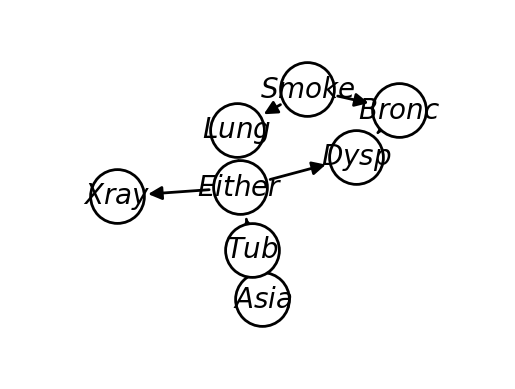

In [2]:
asia_G = y0.examples.asia_example.graph
asia_df = y0.examples.asia_example.data

asia_G.draw()

In [3]:
asia_df

,Asia,Smoke,Tub,Lung,Bronc,Either,Xray,Dysp
0,-1,1,-1,-1,1,-1,-1,1
1,-1,1,-1,-1,-1,-1,-1,-1
2,-1,-1,1,-1,-1,1,1,1
3,-1,-1,-1,-1,1,-1,-1,1
4,-1,-1,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...
4995,-1,-1,-1,-1,1,-1,1,1
4996,-1,-1,-1,-1,-1,-1,-1,-1
4997,-1,-1,-1,-1,-1,-1,-1,-1
4998,-1,1,-1,-1,-1,-1,-1,1


In [4]:
issues = falsification.get_graph_falsifications(asia_G, asia_df, max_given=2, verbose=True)

Checking d-separations:   0%|          | 0/28 [00:00<?, ?pair/s]

Checking conditionals:   0%|          | 0/17 [00:00<?, ?it/s]

/Users/cthoyt/.virtualenvs/y0/lib/python3.12/site-packages/pgmpy/factors/base.py:80: SyntaxWarning: invalid escape sequence '\s'
  """
/Users/cthoyt/.virtualenvs/y0/lib/python3.12/site-packages/pgmpy/extern/tabulate.py:151: SyntaxWarning: invalid escape sequence '\h'
  return "\\begin{tabular}{" + tabular_columns_fmt + "}\n\hline"
/Users/cthoyt/.virtualenvs/y0/lib/python3.12/site-packages/pgmpy/extern/tabulate.py:256: SyntaxWarning: invalid escape sequence '\['
  _invisible_codes = re.compile("\x1b\[\d*m")  # ANSI color codes
/Users/cthoyt/.virtualenvs/y0/lib/python3.12/site-packages/pgmpy/extern/tabulate.py:257: SyntaxWarning: invalid escape sequence '\['
  _invisible_codes_bytes = re.compile(b"\x1b\[\d*m")  # ANSI color codes
/Users/cthoyt/.virtualenvs/y0/lib/python3.12/site-packages/pgmpy/models/MarkovNetwork.py:611: SyntaxWarning: invalid escape sequence '\p'
  """
/Users/cthoyt/.virtualenvs/y0/lib/python3.12/site-packages/pgmpy/models/MarkovNetwork.py:725: SyntaxWarning: invalid e

In [5]:
issues.evidence

,left,right,given,stats,p,dof,p_adj,p_adj_significant
0,Either,Smoke,Lung,0.000000,1.000000,1,1.0,False
1,Bronc,Either,Smoke,2.083750,0.352793,2,1.0,False
2,Asia,Xray,Either,0.000000,1.000000,2,1.0,False
3,Dysp,Xray,Either,0.617808,0.734251,2,1.0,False
4,Asia,Lung,,0.201322,0.653656,1,1.0,False
5,Lung,Xray,Either,0.000000,1.000000,1,1.0,False
6,Asia,Smoke,,1.841060,0.174827,1,1.0,False
7,Lung,Tub,,0.129525,0.718925,1,1.0,False
8,Smoke,Tub,,0.000000,1.000000,1,1.0,False
9,Bronc,Lung,Smoke,3.477138,0.175772,2,1.0,False


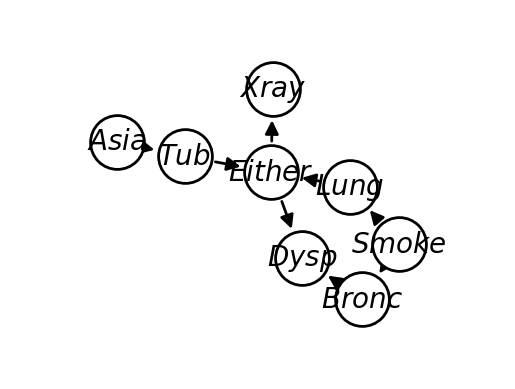

In [6]:
# Should be issues (Lung, Either) AT LEAST.
# .  Seeing issues (Lung, Xray) as well.  Is that all?
# TODO: Check d-separations by hand...
asia_G2 = copy.deepcopy(asia_G)
asia_G2.draw()

In [7]:
asia_G2.directed.remove_edge(
    Variable("Lung"), Variable("Either")
)  # delete_diedge("Lung", "Either")
issues = falsification.get_graph_falsifications(asia_G2, asia_df)

In [8]:
issues.failures

13     (Dysp, Lung, Bronc)
8         (Either, Lung, )
9           (Lung, Xray, )
6        (Either, Smoke, )
11         (Smoke, Xray, )
10       (Bronc, Either, )
15    (Dysp, Smoke, Bronc)
12         (Bronc, Xray, )
dtype: object

In [9]:
issues.evidence

,left,right,given,stats,p,dof,p_adj,p_adj_significant
13,Dysp,Lung,Bronc,296.251065,0.000000e+00,2,0.000000e+00,True
8,Either,Lung,,3099.534805,0.000000e+00,1,0.000000e+00,True
9,Lung,Xray,,2094.106838,0.000000e+00,1,0.000000e+00,True
6,Either,Smoke,,196.335994,1.316547e-44,1,2.369784e-43,True
11,Smoke,Xray,,127.464729,1.469901e-29,1,2.498831e-28,True
10,Bronc,Either,,22.547558,2.050050e-06,1,3.280080e-05,True
15,Dysp,Smoke,Bronc,21.128858,2.581824e-05,2,3.872737e-04,True
12,Bronc,Xray,,14.983980,1.084278e-04,1,1.517989e-03,True
1,Bronc,Lung,Smoke,3.477138,1.757718e-01,2,1.000000e+00,False
2,Tub,Xray,Either,0.000000,1.000000e+00,1,1.000000e+00,False
